In [1]:
from PIL import Image
import numpy as np
from tqdm import tqdm
import os
from glob import glob

import torch
from torch import nn
from torch.utils import data
import torchvision
import torch.nn.functional as F
from  torch.nn.utils import spectral_norm
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from config import Config as cfg
import matplotlib.pyplot as plt
import pandas as pd

import utils
import network
import loss
import dataset

In [15]:
map_files = glob("../data/flickr/maps_raw/*")
ds = dataset.flickrDataset(map_files)
file = map_files[0]
label = Image.open(file)
label = np.array(label)
for k,v in ds.classTableEncoding.items():
    label[label==k] = v
label = Image.fromarray(label)
label = ds.map_transforms(label).squeeze(0)
print(label.dtype)
label = (label*255).long()
label_ohe = F.one_hot(label,num_classes=cfg.NUM_CLASSES).permute(2,0,1).to(torch.float32).unsqueeze(0)
label.shape,label_ohe.shape

torch.float32


(torch.Size([256, 256]), torch.Size([1, 12, 256, 256]))

torch.Size([1, 3, 256, 256])


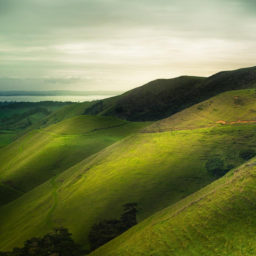

In [32]:
img_files = glob("../data/flickr/style_images/*")
style_image_file = img_files[0]
style_image = Image.open(style_image_file).convert("RGB")
style_image_resized = ds.longest_side_resize(style_image)

x1,x2,y1,y2 = ds.random_crop_dimensions(style_image_resized)
style_image_resized = style_image_resized.crop((x1,y1,x2,y2))
style_image_resized_input = ds.img_transforms(style_image_resized).unsqueeze(0)
print(style_image_resized_input.shape)
style_image_resized

In [3]:
encoder = network.EncoderLarge().to(cfg.DEVICE)
generator = network.GeneratorLarge().to(cfg.DEVICE)
encoder.load_state_dict(torch.load(cfg.ENCODER_WEIGHTS_EVAL))
generator.load_state_dict(torch.load(cfg.GENERATOR_WEIGHTS_EVAL))

<All keys matched successfully>

In [6]:
encoder.eval()
generator.eval()
print()

NameError: name 'latent_vec' is not defined

(256, 256, 3)


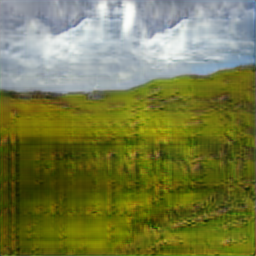

In [33]:
with torch.no_grad():
    style_image_resized_input = style_image_resized_input.to(cfg.DEVICE)
    mu,var = encoder(style_image_resized_input)
    latent_vec = encoder.get_latent_vector(mu,var)
    latent_vec = latent_vec.to(cfg.DEVICE)
    label_ohe = label_ohe.to(cfg.DEVICE)
    fake_image = generator(latent_vec=latent_vec,segmentation_map=label_ohe).squeeze(0)
    fake_image = fake_image.detach().cpu().numpy()
fake_image = np.transpose(fake_image,(1,2,0))
fake_image = (fake_image+1)/2
fake_image = (fake_image*255).astype(np.uint8)
print(fake_image.shape)
Image.fromarray(fake_image)

In [4]:
label_class_map = {v:ds.classTable[k] for k,v in ds.classTableEncoding.items()}
label_class_map

{11: 'bush',
 0: 'clouds',
 5: 'grass',
 7: 'hill',
 2: 'mountain',
 9: 'river',
 6: 'rock',
 8: 'sand',
 4: 'sea',
 1: 'sky-other',
 3: 'tree',
 10: 'water-other'}

In [34]:
a = {11: 'bush',
 0: 'clouds',
 5: 'grass',
 7: 'hill',
 2: 'mountain',
 9: 'river',
 6: 'rock',
 8: 'sand',
 4: 'sea',
 1: 'sky-other',
 3: 'tree',
 10: 'water-other'}
 

In [43]:
canvas_extract = np.zeros((5,5,3))
canvas_extract = np.array([[[-1., -2., -3.],
        [1., 2., 3.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])
canvas_extract[0][0]

array([-1., -2., -3.])

In [52]:
condlist = [canvas_extract==(1,2,3),canvas_extract==(-1,-2,-3)]
choices = ["pos","neg"]
np.select(condlist,choices,"zero")[:,:,0].shape


(5, 5)